<a href="https://colab.research.google.com/github/patlewig/aim/blob/master/notebooks/AIM_Check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import pandas as pd

In [129]:
# Load the original AIM Fragment database And choose dataset of interest (E.g. First 5000 labelled structures)

df = pd.read_csv("aimdb.tsv", sep='\t', names = ['SMILES', 'CASRN', 'othwer', 'other', 'AIM Fragments'])
df_aim = df[['SMILES','CASRN', 'AIM Fragments']]
df_aim['AIM_list'] = df_aim['AIM Fragments'].apply(lambda x: x.split(','))

df_aim = df_aim[0:5000]

df_aim.to_csv('AIM_list_5000_.csv')
df_aim

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,SMILES,CASRN,AIM Fragments,AIM_list
0,N1C(=O)NC(=O)C(F)=C1,51218,"5,10,15,43,58,172,174,176,206,210,3C","[5, 10, 15, 43, 58, 172, 174, 176, 206, 210, 3C]"
1,N(=O)(=O)c(ccc(O)c1N(=O)(=O))c1,51285,"19,23,34,13C","[19, 23, 34, 13C]"
2,Clc1c(Cl)cc(C(O)CNC(C)C)cc1,51296,"0,1,2,7,10,19,21,214,90C","[0, 1, 2, 7, 10, 19, 21, 214, 90C]"
3,c1cc(O)c(O)cc1C(O)CN(Cl)([H])([H])C(C)C,51309,"0,1,2,7,19,23,107,127,214","[0, 1, 2, 7, 19, 23, 107, 127, 214]"
4,CN1C2CC(CC1C3OC23)OC(=O)C(CO)c4ccccc4,51343,"0,1,2,7,8,11,19,40,171,173,174,82C","[0, 1, 2, 7, 8, 11, 19, 40, 171, 173, 174, 82C]"
...,...,...,...,...
4995,FC(C(Cl)C)F,430933,"0,2,12,14","[0, 2, 12, 14]"
4996,O=C(C(=O)C)C,431038,"0,118","[0, 118]"
4997,ClC(F)C(Cl)F,431061,"2,12,14","[2, 12, 14]"
4998,FC(=O)N(C)C,431141,"0,11,14,43,200","[0, 11, 14, 43, 200]"


In [136]:
# Create a list of the CRSML Chemotypes from the fingerprint file generated in Chemotyper 
# (Chemotyper Inputs: Chemotype set file: AIM_V_1.xml, Structures: first_5000.sdf) --> Chemotyper Output: AIM_vs_first_5000.csv

df_chemo = pd.read_csv("AIM_V1_vs_fooba_5030.csv")
df_chemo = df_chemo.rename(columns={'M_SMILES':'SMILES'})
df_chemo['Chemo_list'] = df_chemo.apply(lambda x: x.index[x == 1].tolist(), axis=1)
df_chemo = df_chemo[['SMILES','Chemo_list']]
df_chemo


df_join = pd.merge(df_chemo,df_aim,on='SMILES',how='inner')
df_join = df_join[['CASRN','SMILES','AIM_list', 'Chemo_list']]
df_join = df_join.drop_duplicates(subset=['SMILES'])
#df_join.to_csv('AIM_ChemoType_Bench_first600.csv')

df_join

,CASRN,SMILES,AIM_list,Chemo_list
0,51218,N1C(=O)NC(=O)C(F)=C1,"[5, 10, 15, 43, 58, 172, 174, 176, 206, 210, 3C]","[5, 10, 15, 43, 58, 172, 174, 176, 206, 210, 3C]"
1,51285,N(=O)(=O)c(ccc(O)c1N(=O)(=O))c1,"[19, 23, 34, 13C]","[19, 23, 34, 13C, 13C_b]"
2,51296,Clc1c(Cl)cc(C(O)CNC(C)C)cc1,"[0, 1, 2, 7, 10, 19, 21, 214, 90C]","[0, 1, 2, 7, 10, 19, 21, 214, 90C]"
3,51343,CN1C2CC(CC1C3OC23)OC(=O)C(CO)c4ccccc4,"[0, 1, 2, 7, 8, 11, 19, 40, 171, 173, 174, 82C]","[0, 1, 2, 7, 8, 11, 19, 40, 171, 173, 174, 82C]"
4,51354,O=C(O)C(NCC1O)C1,"[1, 2, 7, 10, 35, 171, 174, 6C, 7C]","[1, 2, 7, 10, 35, 171, 174, 7C_a, 7C_b]"
...,...,...,...,...
4745,426131,CC1CC2C3CCC(O)(C(=O)C)C3(C)CC(O)C2(F)C4(C)C=CC...,"[0, 1, 2, 5, 7, 14, 29, 76, 92, 171, 172, 176,...","[0, 1, 2, 5, 7, 14, 29, 76, 92, 171, 172, 176,..."
4746,427009,c(cc(c1C2(CC3)C4C5)CC4N3C)c(O)c1OC2CC5,"[0, 1, 2, 11, 19, 23, 25, 76, 171, 173, 174, 8...","[0, 1, 2, 11, 19, 23, 25, 76, 171, 173, 174, 8..."
4747,427510,C12(C)CCC3C4(C)C5CC5C(=O)C=C4C=CC3C1CCC2(C(=O)C)O,"[0, 1, 2, 5, 7, 29, 76, 92, 171, 172, 176, 82C...","[0, 1, 2, 5, 7, 29, 76, 92, 171, 172, 176, 82C..."
4748,428375,N1(C)CC(CCC)(c2cc(O)ccc2)CC1,"[0, 1, 11, 19, 23, 76, 171, 174, 90C]","[0, 1, 11, 19, 23, 76, 171, 174, 90C]"


In [151]:
d = []
for row in df_join.itertuples():
    #combined = row.AIM_list+row.Chemo_list
    combined_uniques = list(set(row.AIM_list).symmetric_difference(set(row.Chemo_list)))
    #combined_uniques = (set(combined))
    d.append(combined_uniques)



df_join['Difference'] = d
#mask = df_join['AIM_list'].apply(lambda x: '5' in x)  #optional filter
#df_join = df_join[mask]       #Optional filter


df_join.to_excel('benchmark_smiles_aim_2_16_22_.xlsx')



# Exceptions due to multiple subgraph representation for a single feature, duplicate entries, or uncaught exceptions
exceptions = ['91C','91C_a','200C','200C_a','123C', '123C_a', 
                     '12','12_a','3_a','3','137', '146', '96E', '328C', '306C', 
                     '66E', '67E', '90E', '100C', '100Ca', '13C', '13C_a',
                     '13C_b','13C_c','13C_d','13C_e', '13C_f', '13C_g',
                     '13C_h', '8', '8_a', '8_b', '82C_a', '82C',
                     '183C', '183C_a', '171','171_a', '216', '216_a',
                     '2', '86C', '99C', '99C_a', '25', '30', '14C',
                     '14C_a', '40', '251C', '24_a', '34C', '34C_a']
for e in exceptions:
  df_join['Difference'] = df_join.Difference.apply(lambda x: [i for i in x if i != e])


df_mismatch = df_join[df_join['Difference'].map(lambda d: len(d)) > 0]

full_match = round(1 -(len(df_mismatch)/len(df_join)),4)

#print(df_mismatch)

print('Percent full match: ' + str(100*full_match) + '%')

df_join

Percent full match: 91.14%


,CASRN,SMILES,AIM_list,Chemo_list,Difference
0,51218,N1C(=O)NC(=O)C(F)=C1,"[5, 10, 15, 43, 58, 172, 174, 176, 206, 210, 3C]","[5, 10, 15, 43, 58, 172, 174, 176, 206, 210, 3C]",[]
1,51285,N(=O)(=O)c(ccc(O)c1N(=O)(=O))c1,"[19, 23, 34, 13C]","[19, 23, 34, 13C, 13C_b]",[]
2,51296,Clc1c(Cl)cc(C(O)CNC(C)C)cc1,"[0, 1, 2, 7, 10, 19, 21, 214, 90C]","[0, 1, 2, 7, 10, 19, 21, 214, 90C]",[]
3,51343,CN1C2CC(CC1C3OC23)OC(=O)C(CO)c4ccccc4,"[0, 1, 2, 7, 8, 11, 19, 40, 171, 173, 174, 82C]","[0, 1, 2, 7, 8, 11, 19, 40, 171, 173, 174, 82C]",[]
4,51354,O=C(O)C(NCC1O)C1,"[1, 2, 7, 10, 35, 171, 174, 6C, 7C]","[1, 2, 7, 10, 35, 171, 174, 7C_a, 7C_b]","[7C_a, 7C_b, 7C, 6C]"
...,...,...,...,...,...
4745,426131,CC1CC2C3CCC(O)(C(=O)C)C3(C)CC(O)C2(F)C4(C)C=CC...,"[0, 1, 2, 5, 7, 14, 29, 76, 92, 171, 172, 176,...","[0, 1, 2, 5, 7, 14, 29, 76, 92, 171, 172, 176,...",[]
4746,427009,c(cc(c1C2(CC3)C4C5)CC4N3C)c(O)c1OC2CC5,"[0, 1, 2, 11, 19, 23, 25, 76, 171, 173, 174, 8...","[0, 1, 2, 11, 19, 23, 25, 76, 171, 173, 174, 8...",[]
4747,427510,C12(C)CCC3C4(C)C5CC5C(=O)C=C4C=CC3C1CCC2(C(=O)C)O,"[0, 1, 2, 5, 7, 29, 76, 92, 171, 172, 176, 82C...","[0, 1, 2, 5, 7, 29, 76, 92, 171, 172, 176, 82C...",[]
4748,428375,N1(C)CC(CCC)(c2cc(O)ccc2)CC1,"[0, 1, 11, 19, 23, 76, 171, 174, 90C]","[0, 1, 11, 19, 23, 76, 171, 174, 90C]",[]


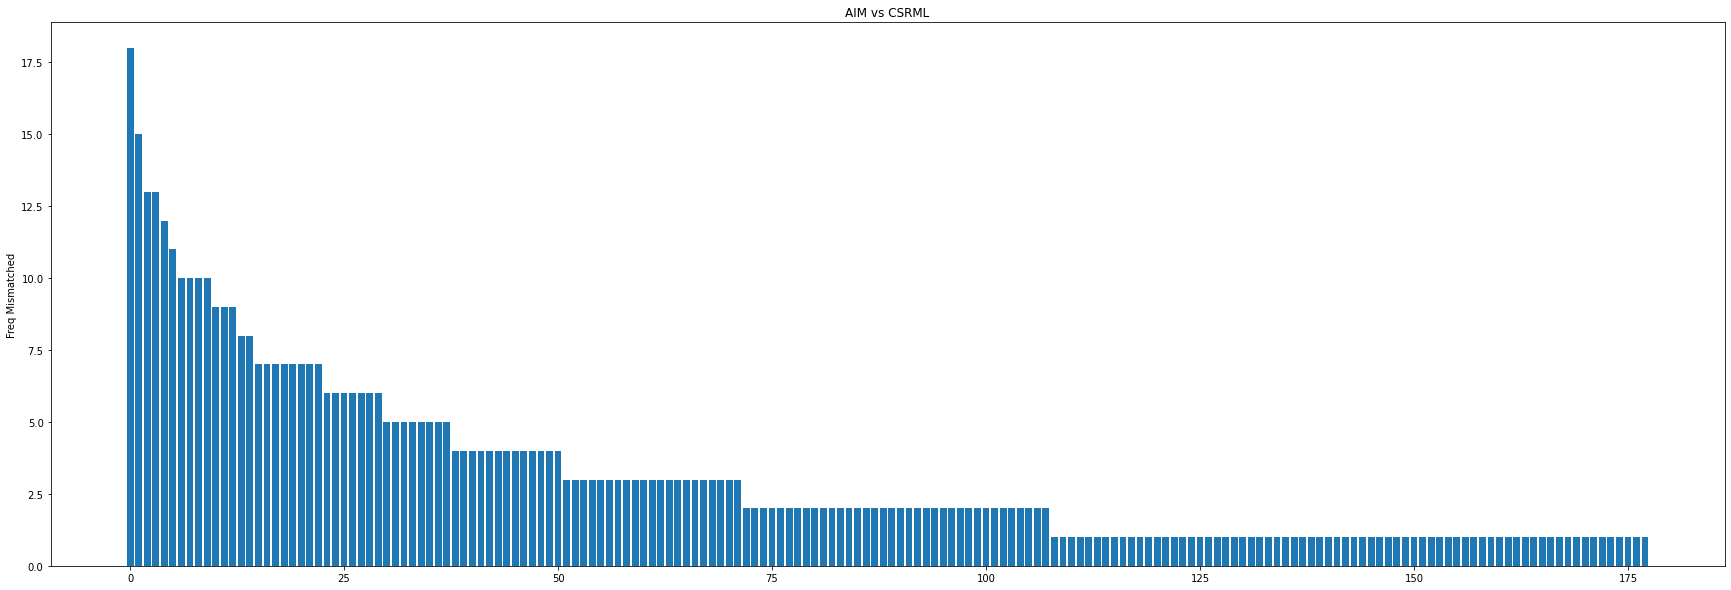

In [152]:
import matplotlib.pyplot as plt
import numpy as np
diff = []
for row in df_join["Difference"]:
  for fragment in row:
    diff.append(fragment)

import collections
diff_counter = collections.Counter(diff)
diff_counter = dict(sorted(diff_counter.items(), key=lambda item: -item[1]))
# Descending order

entries_to_remove = ('91C','91C_a','200C','200C_a','123C', '123C_a', 
                     '12','12_a','3_a','3','137', '146', '96E', '328C', '306C', 
                     '66E', '67E', '90E', '100C', '100Ca', '13C', '13C_a',
                     '13C_b','13C_c','13C_d','13C_e', '13C_f', '13C_g',
                     '13C_h', '8', '8_a', '8_b', '82C_a', '82C',
                     '183C', '183C_a', '171','171_a', '216', '216_a',
                     '2', '86C', '99C', '99C_a', '25', '30', '14C',
                     '14C_a', '40', '251C', '24_a', '101X')#,  '155C')


for k in entries_to_remove:
    diff_counter.pop(k, None)

keys = diff_counter.keys()
#print(keys)

key_len = np.arange(len(keys))
values = diff_counter.values()

plt.figure(figsize=(30, 10))
plt.bar(key_len,values)
plt.ylabel('Freq Mismatched')
plt.title('AIM vs CSRML')
#plt.xticks(key_len, keys)
plt.show()
#print(diff_counter)

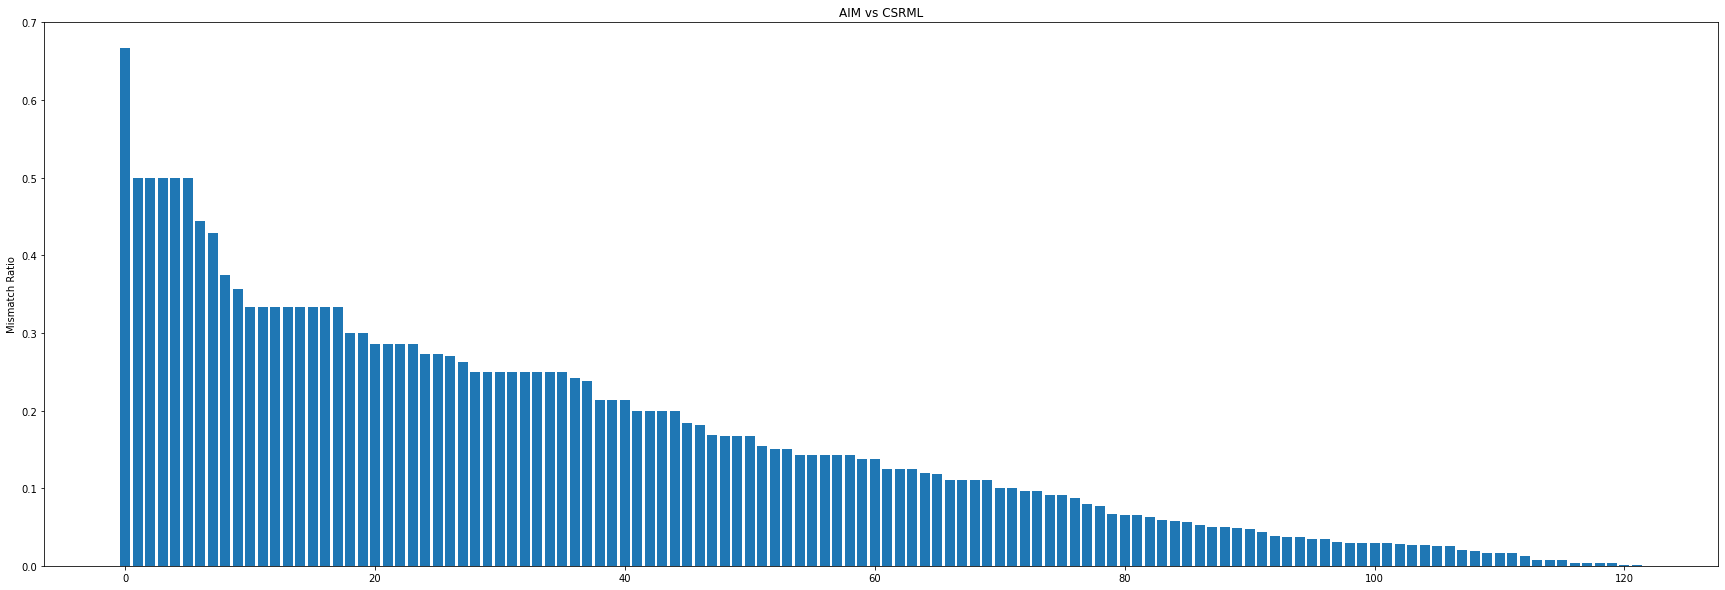

In [154]:
## mismatches / presence_in_list

def col_to_list(col):
  col_list = []
  for row in df_join[col]:
    for fragment in row:
      col_list.append(fragment)
  return col_list

AIM = col_to_list('AIM_list')
counter_aim = collections.Counter(AIM)
AIM_count = dict(counter_aim)
#print(AIM_count['269C'])

diff = col_to_list('Difference')
counter_diff = collections.Counter(diff)
diff_count = dict(counter_diff)
#print(diff_count['269C'])


fraction_mismatched = {k: round(diff_count[k] / float(AIM_count[k]),3) for k in diff_count if k in AIM_count}
fraction_sorted = dict(sorted(fraction_mismatched.items(), key=lambda item: -item[1]))
#print(fraction_mismatched)
entries_to_remove = ('91C','91C_a','200C','200C_a','123C', '123C_a', 
                     '12','12_a','3_a','3','137', '146', '96E', '328C', '306C', 
                     '66E', '67E', '90E', '100C', '100Ca', '13C', '13C_a',
                     '13C_b','13C_c','13C_d','13C_e', '13C_f', '13C_g',
                     '13C_h', '8', '8_a', '8_b', '82C_a', '82C',
                     '183C', '183C_a', '171','171_a', '216', '216_a',
                     '2', '86C', '99C', '99C_a', '25', '30', '14C',
                     '14C_a', '40', '251C', '24_a', '34C', '34C_a',
                     '35C', '35C_a', '101X', '106C_a', '157C',
                     '157C_a', '157C_b', '101C', '101C_a',
                     '106C', '106C_a', '106C_b', '23C', '62E', 
                     '7C', '7C_a', '7C_b', '121', '164',
                     '26C','26C_a','26C_b','26C_c','26C_d',
                     '191C', '191C_a', '107C_a', '107C_b', '107C',
                     '40C')
#121, 164 - both Nitroso, N+5 Valence

for k in entries_to_remove:
    fraction_sorted.pop(k, None)

keys = fraction_sorted.keys()

key_len = np.arange(len(keys))
values = fraction_sorted.values()

plt.figure(figsize=(30, 10))
plt.bar(key_len,values)
plt.ylabel('Mismatch Ratio')
plt.title('AIM vs CSRML')
#plt.xticks(key_len, keys)
plt.show()

#print(fraction_sorted)  


In [140]:
fragments = []
for row in df_join["Difference"]:
  for fragment in row:
    fragments.append(fragment)
  #print(df_benchmark["Organic functional groups (US EPA)"][row])
  
i = list(set(fragments)) #list of unique fragments
duplicates = ['137', '146', '96E', '328C', '306C', '66E', '67E', '90E']
#maybe some AIM wrong: 3, 8, 23C, 76, 2, 124C, 216, 29
aim_error = ['1','2','3','8', '20','29','211', '12','174', '76','175', '101X','99','5C','14C','191C','40C', '181C', '84', '191C', '62E', '121', '178', '43', '25', '151C', '155C', '82C']  # maybe 121; CAS 69749, 61734,75172, 50760, 58253 is wrong on AIM, (weird aromatic)
final_list = list(set(i) - set(duplicates)- set(aim_error))
print(len(final_list))   # Length of list (# unique different fragments)



160


In [141]:
# Takes a few minutes to run
df_join
fragments = []
for row in df_join["AIM_list"]:
  for fragment in row:
    fragments.append(fragment)

#print(fragments)
diffs = []

for i in fragments:
  selection = [i]

  mask = df_join['Difference'].apply(lambda x: any(item for item in selection if item in x))

  df_diff = df_join[mask]

  diff_total = df_diff.shape[0]

  chemo_mask = df_diff['Chemo_list'].apply(lambda x: any(item for item in selection if item in x))

  diff_chemo = df_diff[chemo_mask].shape[0]
  diff_aim = diff_total - diff_chemo
  diffs.append([diff_total,diff_chemo,diff_aim])

#print(diffs)

In [146]:
# Create a dictionary using the above data
diffs_dict = dict(zip(fragments,diffs))
diffs_dict = {key:val for key, val in diffs_dict.items() if val != [0, 0, 0]}  #Get rid of ones with no diffs

#diffs_dict
# [total diff, AIM MISSING, CSRML MISSING]

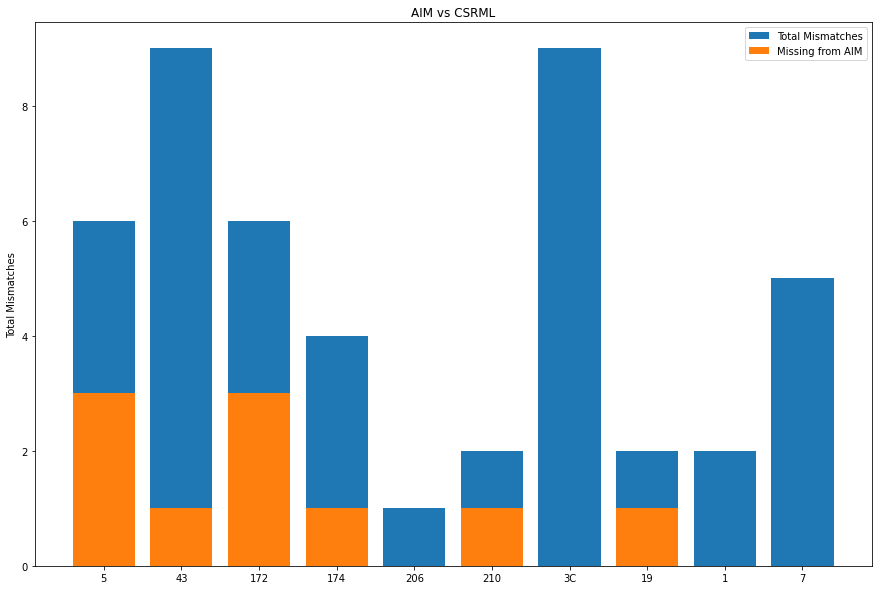

In [145]:
keys = diffs_dict.keys()

key_len = np.arange(len(keys))

n = 10
first_n_pairs = {k: diffs_dict[k] for k in list(diffs_dict)[:n]}

keys = first_n_pairs.keys()

key_len = np.arange(len(keys))


values = list(first_n_pairs.values())
values_0 = [item[0] for item in values]
values_1 = [item[1] for item in values]
values_2 = [item[2] for item in values]


plt.figure(figsize=(15, 10))
plt.bar(key_len, values_0, label='Total Mismatches')
plt.bar(key_len, values_1, label='Missing from AIM')

plt.ylabel('Total Mismatches')
plt.title('AIM vs CSRML')
plt.legend()
plt.xticks(key_len, keys)
plt.show()

In [147]:
#AIM_count